In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def set_device(use_gpu):
    """Set the device to run the code.

    Choose CUDA (GPU) if you want to use & it is available,
    if not, choose CPU.

    Args:
        use_gpu (bool): whether you want to use GPU
    Returns:
        Torch.device: device to use in the code
    """
    if use_gpu and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using Device: {device}")
    return device

# Test the function
device = set_device(use_gpu="True")
print(f"Device: {device}")

Using Device: cuda
Device: cuda


In [ ]:
class Config:
    def __init__(
        self,
        use_gpu=True,
        lr=1e-2,
        epoch=5,
        log_interval=100,
        dataset_path='./datasets',
        image_size=32,
        num_train_data=49000,
        batch_size=64,
        mlp_hidden_dim=512,
        cnn_in_channel=3,
        cnn_channel1=12,
        cnn_channel2=8,
    ):
        # 모델 학습 관련 설정
        self.use_gpu = use_gpu # GPU 사용 여부
        self.lr = lr # learning rate
        self.epoch = epoch # epoch 수
        self.log_interval = log_interval # 실행 상황을 출력할 빈도

        # 데이터셋 설정
        self.dataset_path = dataset_path # 데이터셋을 다운받을 위치
        self.classes = ( # 클래스 종류
            'plane', 'car', 'bird', 'cat','deer',
            'dog', 'frog', 'horse', 'ship', 'truck',
        )
        self.num_classes = len(self.classes) # 클래스 개수
        self.image_size = image_size # 이미지의 가로/세로 크기

        # 데이터 로더 설정
        self.num_train_data = num_train_data # training set으로 사용할 이미지 개수
        self.batch_size = batch_size # 한 배치 당 이미지 개수. GPU 성능이 낮을 경우 더 낮게 설정. 보통 2의 제곱수.

        # FCN 사용 시 설정
        self.mlp_input_size = self.image_size * self.image_size * 3 # MLP 입력 크기
        self.mlp_hidden_dim = mlp_hidden_dim # MLP hidden layers의 데이터 차원

        # CNN 사용 시 설정
        self.cnn_in_channel = cnn_in_channel # CNN 입력 채널 수
        self.cnn_channel1 = cnn_channel1 # CNN 은닉층1 채널 수
        self.cnn_channel2 = cnn_channel2 # CNN 은닉층2 채널 수

        # 실행 디바이스 설정
        self.device = set_device(self.use_gpu)

        # 데이터셋 다운로드 폴더 생성
        if not os.path.exists(self.dataset_path):
            os.makedirs(self.dataset_path, exist_ok=True)

In [ ]:
def get_transform():
    transform = T.Compose([
        T.ToTensor(), # 텐서화
        T.Normalize(  # 정규화 (각 채널의 mean과 std를 지정)
            mean = (0.5, 0.5, 0.5),
            std  = (0.5, 0.5, 0.5),
        ),
    ])
    return transform

In [ ]:
def make_dataloader(dataset_path, batch_size, transform):
    # Dataset split
    cifar10_train = torchvision.datasets.CIFAR10(
        dataset_path, train=True, download=True, transform=transform,
    )

    cifar10_val = torchvision.datasets.CIFAR10(
        dataset_path, train=True, download=True, transform=transform,
    )

    cifar10_test = torchvision.datasets.CIFAR10(
        dataset_path, train=False, download=True, transform=transform,
    )

    # Dataloader
    loader_train = DataLoader(
        dataset    = cifar10_train,
        batch_size = batch_size,
        shuffle    = True, # 데이터셋 내 데이터를 가져오는 순서를 섞음
        drop_last  = True, # 맨 마지막 배치가 배치 크기에 맞지 않을 경우 버림
    )

    loader_val = DataLoader(
        dataset    = cifar10_val,
        batch_size = batch_size,
        shuffle    = True,
    )

    loader_test = DataLoader(
        dataset    = cifar10_test,
        batch_size = batch_size,
        shuffle    = False,
    )

    return loader_train, loader_val, loader_test


In [ ]:
############################################################################
# Req 2-1: 데이터셋 내 데이터를 시각화하는 함수 구현                             #
############################################################################
def visualize(img):
    """
    Args:
        img (torch.Tensor): A image to visualize, shape: [C, H, W]
    """
    ################################################################################
    # TODO: 데이터로더가 가져온 데이터셋 내 이미지(`img`)를 입력 받아 transform되었던      #
    # 형태를 다시 되돌리고, 이를 화면에 출력한다.                                        #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) [-1, 1] 범위로 normalize된 데이터를 [0, 1] 범위로 unnormalize
    img = (img + 1) / 2  # [-1, 1] -> [0, 1]

    # 2) Tensor형인 이미지를 numpy 배열로 변환
    img = img.numpy()

    # 3) [Channel, Hight, Width] 순서의 축을 [Hight, Width, Channel] 순서로 변경
    img = np.transpose(img, (1, 2, 0))  # [C, H, W] -> [H, W, C]

    # 4) matplotlib의 plt.imshow() 함수로 시각화
    plt.imshow(img)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################


Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


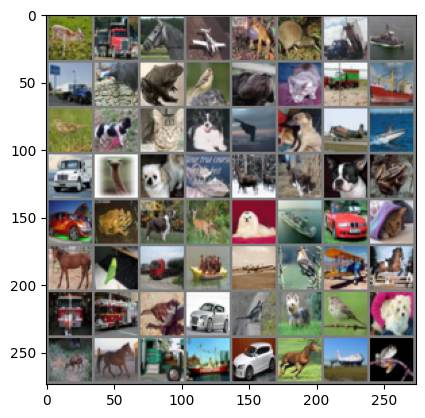

In [ ]:
# 실행 디바이스 및 configuration 설정
config = Config()

# 이미지 데이터의 transform 정의하기
transform = get_transform()

# 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
    dataset_path=config.dataset_path,
    batch_size=config.batch_size,
    transform=transform,
)

# 데이터셋의 하나를 뽑아 시각화 함수 사용해보기
images, labels = next(iter(train_loader))
visualize(torchvision.utils.make_grid(images))

In [ ]:
############################################################################
# Req 2-2: TwoLayerFC 모델 구성하기                                          #
############################################################################

class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_dim, num_class):
        """
        Define model layers and initialize model weights

        Args:
            input_size  (int): dimension of input data
            hidden_dim (int): dimension of hidden state
            num_class (int): the number of data classes
        """
        super().__init__()

        ################################################################################
        # TODO: 조건에 맞게 모델의 레이어를 정의함                                          #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

         # 1) 이미지를 flatten 할 Linear layer 정의


        # 2) 두 개의 FC layer와 그 사이를 잇는 ReLU 활성화함수를 nn.Sequential로 묶어서 하나의 모듈로 정의
        #    - 첫 번째 FC: input data -> hidden feature
        #    - ReLU activation function
        #    - 두 번째 FC: hidden feature -> output (각 클래스 별 classification 점수)

        # 이미지를 flatten할 레이어 정의
        self.flatten = nn.Flatten()
        # 두 fully connected layer 정의 & Sequential로 묶기
        self.linear_block = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_class)
        )

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

    def forward(self, x):
        """
        Define the forward pass of network

        Args:
            x (torch.Tensor): Input data (shape - [B, C, H, W])
        Returns:
            torch.Tensor:
                Results of forward pass which are classification scores
                of each data for each class. (shape - [B, num_class])
        """
        ################################################################################
        # TODO: __init__에서 정의한 레이어 및 모듈을 활용하여 이미지가 각 클래스 별 점수로 나오는 #
        # 연산을 수행함                                                                  #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # 1) 이미지를 flatten하기
        x = self.flatten(x)

        # 2) FC, ReLU, FC를 거쳐 최종 출력(각 클래스 별 classification 점수)인 리턴값을 구하기
        x = self.linear_block(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return x


In [ ]:
# 모델을 선언하기
model = TwoLayerFC(
    input_size = config.mlp_input_size,
    hidden_dim = config.mlp_hidden_dim,
    num_class  = config.num_classes,
)

# 모델의 레이어 구성 확인하기
print(model)

# 모델의 파라미터 확인하기
for name, param in model.named_parameters():
    print(f"Layer: {name}\nSize: {param.size()}\nValues : {param[:2]} \n")

TwoLayerFC(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_block): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Layer: linear_block.0.weight
Size: torch.Size([512, 3072])
Values : tensor([[-0.0156,  0.0050,  0.0028,  ...,  0.0163, -0.0035, -0.0034],
        [-0.0080, -0.0051,  0.0094,  ..., -0.0087,  0.0146, -0.0030]],
       grad_fn=<SliceBackward0>) 

Layer: linear_block.0.bias
Size: torch.Size([512])
Values : tensor([-0.0158,  0.0102], grad_fn=<SliceBackward0>) 

Layer: linear_block.2.weight
Size: torch.Size([10, 512])
Values : tensor([[ 0.0279, -0.0288, -0.0246,  ...,  0.0219, -0.0383,  0.0239],
        [ 0.0034,  0.0383, -0.0174,  ..., -0.0065, -0.0030, -0.0091]],
       grad_fn=<SliceBackward0>) 

Layer: linear_block.2.bias
Size: torch.Size([10])
Values : tensor([0.0237, 0.0192], grad_fn=<SliceBackward0>) 



In [ ]:
############################################################################
# Req 2-3: 모델을 학습시키는 train() 함수 구현하기                              #
############################################################################

def train(model, train_loader, optimizer, device, log_interval=50):
    model.train()  # 모델을 train 모드로 설정합니다.

    for step, (data, target) in enumerate(train_loader):  # 각 데이터 배치로 각 step을 학습
        ################################################################################
        # TODO: 데이터 배치 하나를 처리하는 train 프로세스를 구현함. Optimizer에서 gradient를  #
        # 초기화하고, 데이터를 불러오며, 모델의 예측값을 얻고, 정답 값과 차이를 구해 loss로 삼음.  #
        # loss를 backpropagation하고 네트워크의 가중치를 업데이트함.                         #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1) Optimizer `optimizer`의 gradient 값을 초기화
        # 2) 배치 내 데이터를 불러오고 `device`로 데이터가 올라갈 디바이스를 지정함
        # 3) Forward pass를 통해 모델의 출력(예측값)을 생성함
        # 4) cross entropy loss를 계산함
        # 5) Loss를 backpropagation하여 gradient를 전달함
        # 6) optimizer로 네트워크 가중치를 업데이트함
        # 7) [Optional] 로깅 용으로 loss를 출력함

        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        output = model(data)

        loss = F.cross_entropy(output, target)

        loss.backward()

        optimizer.step()

        # [Optional] 로깅 용으로 loss를 출력함
        if step % log_interval == 0:
            print(f"Step {step} / {len(train_loader)-1} | Loss {loss.item():.4f}")

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################


In [ ]:
############################################################################
# Req 2-4: 모델을 평가하는 test() 함수 구현하기                                #
############################################################################

def test(model, dataloader, device, mode="val"):
    ################################################################################
    # TODO: 실제 클래스를 모델의 예측이 얼마나 잘 맞추었는지 accuracy를 측정함             #
    # 전체 validation/test set을 돌면서 맞춘 개수를 누적해서 더하고, 전체 개수로 나누어     #
    # accuracy를 측정할 수 있음. 한 배치에 대한 처리 과정을 구현함.                       #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    cnt_correct = 0  # 전체 셋 중 정답을 맞춘 개수
    tot_num = len(dataloader.dataset)  # 전체 개수
    tot_loss = 0  # loss 총합 (validation 모드에서만 사용)

    model.eval()  # 모델을 eval 모드로 전환. Batch Normalization을 수행하지 않는 등 필요 없는 작업을 자동으로 끔.

    with torch.no_grad():  # gradient 계산을 하지 않음.
        for data, target in dataloader:  # 각 데이터 배치로 각 step을 학습
            # 1) 배치 내 데이터를 불러오고 `device`로 데이터가 올라갈 디바이스를 지정함
            data, target = data.to(device), target.to(device)

            # 2) Forward pass를 통해 모델의 출력(예측값)을 생성함
            output = model(data)

            # 3) `mode`가 validation(`val`)일 때는 loss 값을 계산함
            if mode == "val":
                loss = F.cross_entropy(output, target)
                tot_loss += loss.item()

            # 4) 예측한 클래스를 추출함(top-1). 예측값이 각 클래스의 점수이므로, 값이 최대인 클래스를 찾음
            _, predicted = torch.max(output, 1)

            # 5) 정답을 맞춘 개수를 누적합함
            cnt_correct += (predicted == target).sum().item()

        # 6) Accuracy를 계산함
        accuracy = cnt_correct / tot_num

        # 결과를 출력함
        print("-"*30)
        if mode == "val":
            print(f"Validation Loss: {tot_loss / len(dataloader):.4f}")
        print(f"Accuracy: {accuracy:.2f} ({cnt_correct} / {tot_num})")
        print("-"*30)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################


In [ ]:
############################################################################
# Req 2-5: 모델 학습 진행하기                                                 #
############################################################################

################################################################################
# TODO: 학습에 사용할 설정값을 불러오고, 데이터셋 및 데이터로더를 불러오며,              #
# 모델 및 optimizer을 선언하고, 학습 iteration을 수행하는 과정을 구현함.              #
# 앞서 각 단계를 구현해두었으므로, 이를 종합하여 실행하는 단계임.                       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 1) 실행 디바이스 및 configuration 설정
config = Config()

# 2) 이미지 데이터의 transform 정의하기
transform = get_transform()

# 3) 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
    dataset_path=config.dataset_path,
    batch_size=config.batch_size,
    transform=transform,
)

# 4) 모델을 선언하기
model = TwoLayerFC(
    input_size=config.mlp_input_size,
    hidden_dim=config.mlp_hidden_dim,
    num_class=config.num_classes
)

# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
model.to(config.device)

# 6) Optimizer 선언하기: SGD 사용
optimizer = optim.SGD(model.parameters(), lr=config.lr)

# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기
for epoch in range(config.epoch):
    print(f"Epoch {epoch+1}/{config.epoch}")

    # 학습 수행
    train(model, train_loader, optimizer, config.device, log_interval=config.log_interval)

    # 검증 수행
    test(model, val_loader, config.device, mode="val")

# 테스트 데이터셋으로 최종 성능 평가
test(model, test_loader, config.device, mode="test")

Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5
Step 0 / 780 | Loss 2.2961
Step 100 / 780 | Loss 2.0499
Step 200 / 780 | Loss 2.0433
Step 300 / 780 | Loss 2.0436
Step 400 / 780 | Loss 1.7792
Step 500 / 780 | Loss 1.7725
Step 600 / 780 | Loss 1.7009
Step 700 / 780 | Loss 1.6096
------------------------------
Validation Loss: 1.7061
Accuracy: 0.41 (20435 / 50000)
------------------------------
Epoch 2/5
Step 0 / 780 | Loss 1.8486
Step 100 / 780 | Loss 1.6372
Step 200 / 780 | Loss 1.7889
Step 300 / 780 | Loss 1.5051
Step 400 / 780 | Loss 1.5577
Step 500 / 780 | Loss 1.6326
Step 600 / 780 | Loss 1.5711
Step 700 / 780 | Loss 1.6952
------------------------------
Validation Loss: 1.5916
Accuracy: 0.45 (22528 / 50000)
------------------------------
Epoch 3/5
Step 0 / 780 | Loss 1.4470
Step 100 / 780 | Loss 1.4590
Step 200 / 780 | Loss 1.6380
Step 300 / 780 | Loss 1.6204
Step 400 / 780 | Loss 1.3365


In [59]:
############################################################################
# Req 2-6: ThreeLayerConvNet 모델 구성하기                                    #
############################################################################

class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_class):
        """
        Define model layers and initialize model weights

        Args:
            in_channel (int): number of channels of input data
            channel_1 (int): output channels of first conv layer and input channels of second conv layer
            channel_2 (int): output channels of second conv layer
            num_class (int): the number of data classes
        """
        super().__init__()

        # 1) in_channel -> channel_1으로 가는 첫 번째 convolution layer 정의
        self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2)

        # 2) channel_1 -> channel_2으로 가는 두 번째 convolution layer 정의
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)

        # 3) ReLU 활성화 함수 정의
        self.relu = nn.ReLU()

        # 4) hidden feature를 클래스 별 분류 점수로 바꿀 FC layer 정의
        # 먼저, Convolution 레이어의 출력 크기를 계산하여 FC 레이어의 입력 크기를 결정합니다.
        self.fc_input_dim = self._get_fc_input_dim(in_channel, channel_1, channel_2)
        self.fc = nn.Linear(self.fc_input_dim, num_class)

    def _get_fc_input_dim(self, in_channel, channel_1, channel_2):
        """
        Compute the number of features going into the fully connected layer.
        """
        with torch.no_grad():
            # Dummy input to get the output size after conv layers
            dummy_input = torch.zeros(1, in_channel, 32, 32)  # Assuming input image size is 32x32
            x = self.conv1(dummy_input)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.relu(x)
            x = x.view(x.size(0), -1)  # Flatten the tensor
            return x.size(1)  # Number of features for the fully connected layer

    def forward(self, x):
        """
        Define the forward pass of network

        Args:
            x (torch.Tensor): Input data (shape - [B, C, H, W])
        Returns:
            torch.Tensor:
                Results of forward pass which are classification scores
                of each data for each class. (shape - [B, num_class])
        """
        # 1) 입력 데이터를 Convolution layer 1, 2와 ReLU 레이어를 통과시키기
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        # 2) hidden features를 [batch크기, 각 feature 크기] 형태로 바꾸기
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # 3) FC layer를 거쳐 최종 출력(각 클래스 별 classification 점수)인 리턴값을 구하기
        scores = self.fc(x)
        return scores

In [60]:
############################################################################
# Req 2-7: 모델 학습 진행하기                                                 #
############################################################################

################################################################################
# TODO: 학습에 사용할 설정값을 불러오고, 데이터셋 및 데이터로더를 불러오며,              #
# 모델 및 optimizer을 선언하고, 학습 iteration을 수행하는 과정을 구현함.              #
# 앞서 각 단계를 구현해두었으므로, 이를 종합하여 실행하는 단계임.                       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 1) 실행 디바이스 및 configuration 설정
config = Config()
device = config.device

# 2) 이미지 데이터의 transform 정의하기
transform = get_transform()

# 3) 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
  dataset_path=config.dataset_path,
  batch_size=config.batch_size,
  transform=transform,
)

# 4) 모델을 선언하기
model = ThreeLayerConvNet(
  in_channel=config.cnn_in_channel,
  channel_1=config.cnn_channel1,
  channel_2=config.cnn_channel2,
  num_class=config.num_classes
)

# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
model.to(device)

# 6) Optimizer 선언하기: SGD 사용
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=0.9)

# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기
for epoch in range(config.epoch):
    print(f"Epoch {epoch+1}/{config.epoch}")

    # 학습 수행
    train(model, train_loader, optimizer, device, log_interval=config.log_interval)

    # 검증 수행
    test(model, val_loader, config.device, mode="val")

# 테스트 데이터셋으로 최종 성능 평가
test(model, test_loader, config.device, mode="test")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5
Step 0 / 780 | Loss 2.3237
Step 100 / 780 | Loss 1.5243
Step 200 / 780 | Loss 1.6017
Step 300 / 780 | Loss 1.6219
Step 400 / 780 | Loss 1.5107
Step 500 / 780 | Loss 1.4470
Step 600 / 780 | Loss 1.2850
Step 700 / 780 | Loss 1.2537
------------------------------
Validation Loss: 1.3094
Accuracy: 0.53 (26526 / 50000)
------------------------------
Epoch 2/5
Step 0 / 780 | Loss 1.3361
Step 100 / 780 | Loss 1.2927
Step 200 / 780 | Loss 1.4350
Step 300 / 780 | Loss 1.5764
Step 400 / 780 | Loss 1.3850
Step 500 / 780 | Loss 1.5506
Step 600 / 780 | Loss 1.1222
Step 700 / 780 | Loss 1.2275
------------------------------
Validation Loss: 1.1262
Accuracy: 0.60 (30249 / 50000)
------------------------------
Epoch 3/5
Step 0 / 780 | Loss 1.1548
Step 100 / 780 | Loss 1.2418
Step 200 / 780 | Loss 1.0410
Step 300 / 780 | Loss 1.4971
Step 400 / 780 | Loss 1.2101


In [62]:
############################################################################
# Req 2-8: 더 높은 정확도의 이미지 분류기 모델 만들기                            #
############################################################################

################################################################################
# TODO: 모델이나 설정값 등 자유롭게 변경하여 이미지 분류기 학습 과정을 구현함            #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 1) 실행 디바이스 및 configuration 설정
config = Config()
device = config.device

# 2) 이미지 데이터의 transform 정의하기
transform = get_transform()

# 3) 데이터로더 불러오기
train_loader, val_loader, test_loader = make_dataloader(
  dataset_path=config.dataset_path,
  batch_size=config.batch_size,
  transform=transform,
)

# 4) 모델을 선언하기
model = ThreeLayerConvNet(
  in_channel=config.cnn_in_channel,
  channel_1=config.cnn_channel1,
  channel_2=config.cnn_channel2,
  num_class=config.num_classes
)

# 5) 모델을 GPU에 올리기 (연산을 GPU로 하기 위함)
model.to(device)

# 6) Optimizer 선언하기: SGD 사용
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=0.9)

# 7) epoch만큼 반복하며 학습-평가를 수행하기: 한 epoch에서 학습 - 평가 순으로 수행하기
for epoch in range(10):
    print(f"Epoch {epoch+1}/10")

    # 학습 수행
    train(model, train_loader, optimizer, device, log_interval=config.log_interval)

    # 검증 수행
    test(model, val_loader, config.device, mode="val")

# 테스트 데이터셋으로 최종 성능 평가
test(model, test_loader, config.device, mode="test")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
Step 0 / 780 | Loss 2.3085
Step 100 / 780 | Loss 1.8424
Step 200 / 780 | Loss 1.5320
Step 300 / 780 | Loss 1.5757
Step 400 / 780 | Loss 1.3941
Step 500 / 780 | Loss 1.3332
Step 600 / 780 | Loss 1.1884
Step 700 / 780 | Loss 1.2231
------------------------------
Validation Loss: 1.2928
Accuracy: 0.53 (26711 / 50000)
------------------------------
Epoch 2/10
Step 0 / 780 | Loss 1.2060
Step 100 / 780 | Loss 1.0298
Step 200 / 780 | Loss 1.0941
Step 300 / 780 | Loss 1.2837
Step 400 / 780 | Loss 1.1303
Step 500 / 780 | Loss 1.4161
Step 600 / 780 | Loss 1.3448
Step 700 / 780 | Loss 1.2642
------------------------------
Validation Loss: 1.1071
Accuracy: 0.61 (30455 / 50000)
------------------------------
Epoch 3/10
Step 0 / 780 | Loss 0.8253
Step 100 / 780 | Loss 1.2539
Step 200 / 780 | Loss 1.1813
Step 300 / 780 | Loss 1.0407
Step 400 / 780 | Loss 1.33